# Lab2 (5IR - 2024): Fall Detection - Supervised learning

**Group name (2 people !):** 

**Names:** MOULIN JEAN-BAPTISTE 

**First names:** Romain Aude

The objectives of this lab are
- Development of a classification model based on artificial neural networks for the fall detection dataset CAUCA,
- Use TensorFlow to determine a performant CNN architecture,
- Study of the architecture of a neural network and the sensitivity of its parameters,
- Use TensorFlow Lite to compress the CNN,
- (Optional) Implementation of Transfer Learning using an efficient architecture (e.g. MobileNetV2).

In [2]:
# # To run on the machines at LAAS, this should be enough:
# # 1) Open your jupyter notebook on Visual Studio Code
# # 2) => Select kernel / Python environments / IA-GPU
# # 3) if needed, go to the extensions, uninstall Python, reload VS, reinstall Python, reload VS 
# # 3) Run this cell
!pip install tensorflow_model_optimization
!pip install pickle5

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.2/241.2 kB 2.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.8/153.8 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.6/240.6 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.9/238.9 kB 7.4 MB/s eta 0:00:00
Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 256.4/256.4 kB 2.8 MB/s eta 0:00:0000:0100:01


In [3]:
from six.moves import cPickle as pickle
import numpy as np
import matplotlib.pyplot as plt
import random
import cv2
import seaborn as sns
import numpy as np
import tempfile
import os
import zipfile
import math
import pickle5 as pickle
# Scikit-learn
from sklearn.metrics import confusion_matrix
# TensorFlow
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, save_model, clone_model, load_model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, BatchNormalization
from tensorflow.keras.utils import to_categorical
# from tensorflow.keras.saving import load_model
from sklearn.model_selection import train_test_split
# TensorFlow Optimization
import tensorflow_model_optimization as tfmot
from tensorflow_model_optimization.sparsity.keras import prune_low_magnitude, PolynomialDecay, UpdatePruningStep, ConstantSparsity

2024-01-19 12:34:20.547844: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/insa/lib:$LD_LIBRARY_PATH
2024-01-19 12:34:20.547944: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# 1. Classification of the CAUCA dataset using Convolutional Neural Netowrks (CNN)

TensorFlow is an open-source machine learning library developed by Google, primarily used for deep learning applications. It provides a comprehensive, flexible ecosystem of tools, libraries, and community resources that enables researchers to develop and deploy machine learning powered applications easily. We use the Python version of the library which can be installed in Python with:
*pip install tensorflow*

We will use the library **tensorflow.keras** to develop ANN of type Convolutional Neural Netowrks (CNN). We use the generic class **Sequential** combined with layers of types:
- **Conv2D**,
- **MaxPooling2D**,
- **BatchNormalization**,
- **Dropout**,
- **Flatten**,
- **Dense**.

<img src="https://miro.medium.com/v2/resize:fit:1400/1*uAeANQIOQPqWZnnuH-VEyw.jpeg" alt="CNN example" />

The documentation for the Tensorflow layers is available at https://www.tensorflow.org/api_docs/python/tf/keras/layers.
Since an example is better than 1000 words, below is a fully working example code for a toy classification problem.

## 1.1 Hand-drawn shapes (HDS) dataset

Some datasets are available on the internet (search Google, Kaggle, and scientific articles). Here, we focus on a small example dataset extracted from the repository: https://github.com/frobertpixto/hand-drawn-shapes-dataset/tree/main. This dataset contains 70x70px images (in .png format) in grayscale of hand-drawn shapes. The images can be of 4 classes: ellipse, triangle, rectangle, others. There are around 50 000 images available. Processing codes are available on github to preprocess the pictures, and build a CNN model for classification.

<img src="https://raw.githubusercontent.com/frobertpixto/hand-drawn-shapes-dataset/main/readme_images/train_images.png" alt="HDS example" />

We have modified the processing code from the repository in order to reduce the dataset for our purpose:
- The images are resized to 14x14px,
- We only keep the classes ellipse, triangle, and rectangle,
- We keep 4 500 images.

The dataset is stored in a pickle file which allows to drop Python data structures to a binary file. The structure is a dictionnary with the data X at key "train_data", and the labes y at key "train_labels":
- Storing:
*save_to_pickle(*
    *"train.pickle",*
    *{*
        *'train_data': train_data,*
        *'train_labels': train_labels*
    *}*
*)*
- Loading
*with open("train.pickle", 'rb') as file:*
    *train_dict = pickle.load(file)*

- Load data
- N.B.: In the obtained labels y, class 1="ellipse", class 2="rectangle", class 3="triangle"

In [3]:
with open("hds_data.pickle", 'rb') as file:
    train_dict = pickle.load(file)
X = train_dict['train_data']
y = train_dict['train_labels'] - 1

Image:  1538


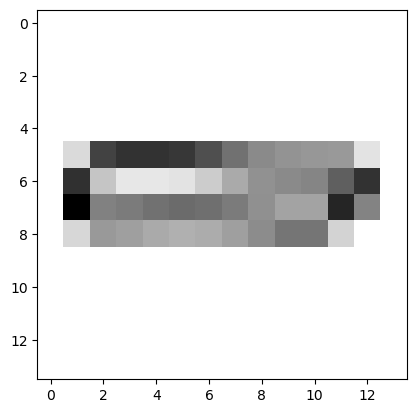

In [4]:
ind = random.randint(0, len(X))
print("Image: ",ind)
plt.imshow(X[ind],cmap=plt.cm.gray_r,interpolation="nearest")
plt.show()

- **Split into train and test datasets**

In [5]:
xtrain, xtest, ytrain, ytest = train_test_split(X, y, train_size=0.8)

# Reshape and normalize the images
xtrain = xtrain.reshape((xtrain.shape[0], 14, 14, 1)).astype('float32')
xtest = xtest.reshape((xtest.shape[0], 14, 14, 1)).astype('float32')

# Convert labels to categorical (one-hot encoding)
ytrain = to_categorical(ytrain)
ytest = to_categorical(ytest)

- **Create the model**

In [6]:
# Building the CNN model
model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(14, 14, 1)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(32, activation='relu'),
    Dense(3, activation='softmax')
])

model.summary()

2024-01-19 08:26:23.942619: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-01-19 08:26:23.952878: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/insa/lib:$LD_LIBRARY_PATH
2024-01-19 08:26:23.952901: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2024-01-19 08:26:23.952927: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (insa-09150): /proc/driver/nvidia/version does not exist
2024-01-19 08:26:23.954266: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 12, 12, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 12, 12, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 6, 6, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1152)              0         
_________________________________________________________________
dense (Dense)                (None, 32)                36896     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 99        
Total params: 37,443
Trainable params: 37,379
Non-trainable params: 64
___________________________________________________

- **Compile and train the model**

In [7]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(xtrain, ytrain, validation_data=(xtest, ytest), epochs=10, batch_size=128)

2024-01-19 08:26:33.306873: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2024-01-19 08:26:33.347817: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 1800000000 Hz


Epoch 1/10
29/29 [==============================] - 2s 31ms/step - loss: 0.9966 - accuracy: 0.5629 - val_loss: 1.0386 - val_accuracy: 0.6822
Epoch 2/10
29/29 [==============================] - 0s 14ms/step - loss: 0.5584 - accuracy: 0.7795 - val_loss: 1.0108 - val_accuracy: 0.6267
Epoch 3/10
29/29 [==============================] - 0s 14ms/step - loss: 0.4358 - accuracy: 0.8328 - val_loss: 0.9798 - val_accuracy: 0.6667
Epoch 4/10
29/29 [==============================] - 0s 13ms/step - loss: 0.3814 - accuracy: 0.8624 - val_loss: 0.9385 - val_accuracy: 0.7022
Epoch 5/10
29/29 [==============================] - 0s 14ms/step - loss: 0.3089 - accuracy: 0.8936 - val_loss: 0.8917 - val_accuracy: 0.6878
Epoch 6/10
29/29 [==============================] - 0s 13ms/step - loss: 0.2590 - accuracy: 0.9068 - val_loss: 0.8498 - val_accuracy: 0.7433
Epoch 7/10
29/29 [==============================] - 0s 13ms/step - loss: 0.2339 - accuracy: 0.9225 - val_loss: 0.7890 - val_accuracy: 0.7822
Epoch 8/10
29

- **TODO: Evaluate the model** (this will help you later):
    - display a random image in the test set with its true and predicted labels,
    - display the accuracy of the CNN on the train and test sets,
    - compute and display the confusion matrix of the model,
    - display the evolution of the accuracy over the training iterations of the CNN.

Image:  872


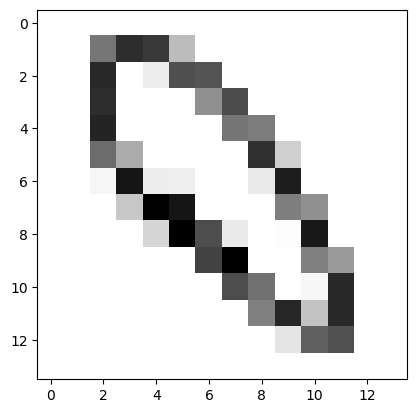

True label: [1. 0. 0.]
Predicted label: [0.4146247  0.3898129  0.19556247]


In [16]:
# display a random image in the test set with its true and predicted labels,
ind = random.randint(0, len(xtest))
print("Image: ",ind)
plt.imshow(xtest[ind],cmap=plt.cm.gray_r,interpolation="nearest")
plt.show()
print("True label: " + str(ytest[ind]))
prediction= model.predict(xtest)
print("Predicted label: "+ str(prediction[ind]))



In [22]:
# display the accuracy of the CNN on the train and test sets,
eval_train=model.evaluate(xtrain,ytrain)
eval_test=model.evaluate(xtest,ytest)
print("format: "+ str(model.metrics_names))
print("accuracy on train set:")
print(eval_train)
print("accuracy on test set:")
print(eval_test)

29/29 [==============================] - 0s 2ms/step - loss: 0.6100 - accuracy: 0.8611
format: ['loss', 'accuracy']
accuracy on train set:
[0.5662648677825928, 0.9358333349227905]
accuracy on test set:
[0.6100314855575562, 0.8611111044883728]


In [45]:
# compute and display the confusion matrix of the model,


# we first create variables in the form [label] instead of [[proba_1,proba_2,proba_3]]
ytest_normalize=[] 
y_predict_normalize=[]
for i in range(len(ytest)):
    max_val_test = 0
    max_ind_test = 0
    max_val_predict = 0
    max_ind_predict = 0
    for j in range(len(ytest[i])):
        if ytest[i][j] > max_val_test:
            max_val_test = ytest[i][j]
            max_ind_test = j
        if prediction[i][j] > max_val_predict:
            max_val_predict = prediction[i][j]
            max_ind_predict = j
    ytest_normalize.append(max_ind_test+1)
    y_predict_normalize.append(max_ind_predict+1)

# NB: We could have used np.argmax
    
matrice=confusion_matrix(ytest_normalize,y_predict_normalize)
print("Confusion matrix:")
print(matrice)

Confusion matrix:
[[251  37  11]
 [ 25 256   8]
 [ 14  30 268]]


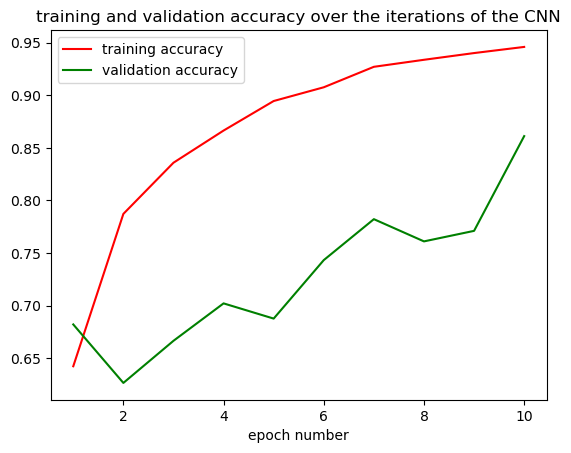

In [44]:
# display the evolution of the accuracy over the training iterations of the CNN.


indices=range(1,11)
plt.plot(indices,history.history["accuracy"],color='r',label="training accuracy")
plt.plot(indices,history.history["val_accuracy"],color='g',label="validation accuracy")


plt.xlabel("epoch number")
plt.title("training and validation accuracy over the iterations of the CNN")
plt.legend()
plt.show()

- **TODO: Questions:** (this will help you later)

    - look at the documentation of Tensorflow (or other) and explain briefly what is the a *Dropout* layer.
    - what does the *to_categorical* function do and why do we modify the labels (ground truth) with it ?
    - what is contained in the prediction for any example ?

- the dropout layer randomly puts some weights to 0 during training, and scales the rest of the weight so the sum over all weights stays the same. This helps to avoid overfitting, as the weights randomly putted to 0 are ignored.
- the *to_categorical* function allows to transform a list of labels (1, 2 or 3 for example) into a list of lists of the following form: [0,0,1] for label 3 for example. Using it to modify the labels comes with several advantages: the model does not consider a notion of distance between the different labels...
- ... and it will predict a probability for each label instead of a scalar 

## 1.2 Classification of the CAUCA dataset

Goal: adapt the example of the HDS dataset classification above to build a performant classifier for the CAUCA dataset. Be creative and do not hesitate to explore CNN architectures !

For example, you can implement the CNN architecture shown above in the picture of the part 2 on CNN.

### CAUCA fall detection dataset

The CAUCA dataset is avalaible at:
https://data.mendeley.com/datasets/7w7fccy7ky/4
The dataset of falls contains data from 10 different activities: Fall backwards, fall forward, fall left, fall right, fall sitting, hop, kneel, pick up object, sit down, walk.
The 20000 labelled images were obtained from videos taken in conditions of an uncontrolled home environment (occlusions, lights, clothes, etc.).
Each of the 10 subjects had to follow a specific protocol, containing the 10 different "activities".

<img src="CAUCA_ex.jpeg" alt="HDS example" />

We have preprocessed the images for a better classification:
- A YOLO model was used to segment the person in each picture, resulting in square images of size ranging between 200 and 350,
- The images were resized to be 96 × 96 or 224 x 224,
- Labels are merged to get : fall vs. non-fall activity.

The datasets are stored in pickle file which allows to drop Python data structures to a binary file. The structure is a dictionnary with the data X at key "train_data", and the labes y at key "train_labels":
- Storing:
*save_to_pickle(*
    *"train.pickle",*
    *{*
        *'data': train_data,*
        *'labels': train_labels,*
        *'width': width,*
        *'height': height,*
        *'channels': channels*
    *}*
*)*
- Loading
*with open("train.pickle", 'rb') as file:*
    *train_dict = pickle.load(file)*

Four sets are available
- Training set (data_train_w_h_c.pickle): images of subjects 1-8,
- Final est set (data_test_w_h_c.pickle): images of subjects 9 and 10.

- **TODO: Explore the training data of images 96 x 96 px**
    - load the data from the corresponding pickle file
    - display an image of the train set for each label (0: non-fall, 1: fall) and display the label
    - split the data into train and validation set
    - transform the labels with *to_categorical*

Image:  0
label: 0


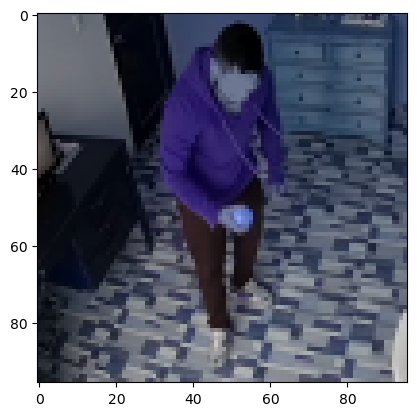

Image:  470
label: 1


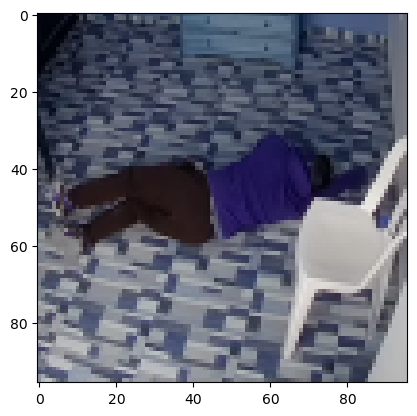

In [30]:
# load the data
with open("data_train_96_96_3.pickle", 'rb') as file:
    train_dict = pickle.load(file)
X = train_dict['data']
y = train_dict['labels']

with open("data_test_96_96_3.pickle", 'rb') as file:
    test_dict = pickle.load(file)
Xtest = test_dict['data']
ytest = test_dict['labels']


# display an image with each label
ind = 0 # we obtain these index thanks to an empirical search on the dataset
print("Image: ",ind)
print("label: " + str(y[ind]))

plt.imshow(X[ind],cmap=plt.cm.gray_r,interpolation="nearest")
plt.show()

ind = 470
print("Image: ",ind)
print("label: " + str(y[ind]))
plt.imshow(X[ind],cmap=plt.cm.gray_r,interpolation="nearest")
plt.show()

# split the data between train and validation 
xtrain, xval, ytrain, yval = train_test_split(X, y, train_size=0.8)


# Convert labels to categorical (one-hot encoding)
ytrain = to_categorical(ytrain)
ytest = to_categorical(ytest)
yval = to_categorical(yval)


- **TODO: Questions:**
    - which activation function is generally used for CNN ?
    - what purpose serve the BatchNormalisation layer ?

- **TODO: Build a CNN classifier for fall detection**
    - Construct as a *Sequential* model the CNN which structure is given as an image in introduction with n1=n2=32, n3=64.
    - Show the number of parameters, and compile the model

- We generally use ReLu
- this layer is used to normalize the data with a mean close to 0 and a standard deviation close to 1 

In [31]:
# Building the CNN model
model = Sequential([
    Conv2D(32, kernel_size=(5, 5), activation='relu', input_shape=(96, 96, 3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(32, kernel_size=(5, 5), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(2, activation='softmax')
])

model.summary()

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 92, 92, 32)        2432      
_________________________________________________________________
batch_normalization (BatchNo (None, 92, 92, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 46, 46, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 42, 42, 32)        25632     
_________________________________________________________________
batch_normalization_1 (Batch (None, 42, 42, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 21, 21, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 14112)             0

- **Training the model**
    - Actual training = fit with 5 epochs (can take some time depending on your architecture),
    - Do not forget to pass the argument *validation_data*,
    - Store the outputs (*history*) !

In [32]:
history = model.fit(xtrain, ytrain, validation_data=(xval, yval), epochs=5, batch_size=128)

Epoch 1/5
40/40 [==============================] - 47s 1s/step - loss: 2.1051 - accuracy: 0.7560 - val_loss: 17.2269 - val_accuracy: 0.4071
Epoch 2/5
40/40 [==============================] - 46s 1s/step - loss: 0.0711 - accuracy: 0.9849 - val_loss: 7.4893 - val_accuracy: 0.4270
Epoch 3/5
40/40 [==============================] - 46s 1s/step - loss: 0.0212 - accuracy: 0.9932 - val_loss: 2.5376 - val_accuracy: 0.6063
Epoch 4/5
40/40 [==============================] - 46s 1s/step - loss: 0.0091 - accuracy: 0.9971 - val_loss: 0.7457 - val_accuracy: 0.7976
Epoch 5/5
40/40 [==============================] - 46s 1s/step - loss: 0.0079 - accuracy: 0.9992 - val_loss: 0.2275 - val_accuracy: 0.9246


- **TODO: Evaluate the model:**
    - display the evolution of the accuracy over the training iterations of the CNN
    - display the accuracy of the model on the train and validation sets,
    - compute and display the confusion matrix of the model.

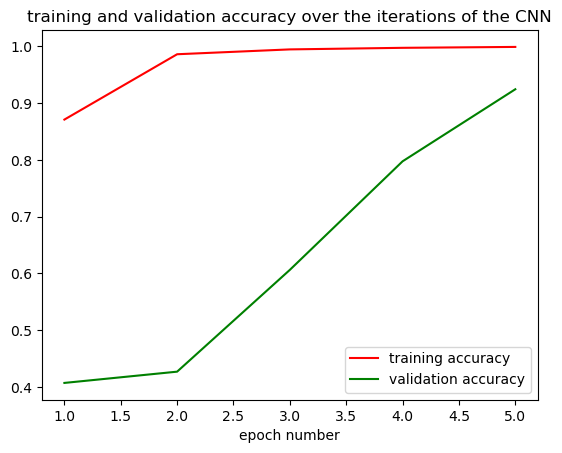

In [33]:
# display the evolution of the accuracy over the training iterations of the CNN.


indices=range(1,6)
plt.plot(indices,history.history["accuracy"],color='r',label="training accuracy")
plt.plot(indices,history.history["val_accuracy"],color='g',label="validation accuracy")


plt.xlabel("epoch number")
plt.title("training and validation accuracy over the iterations of the CNN")
plt.legend()
plt.show()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 92, 92, 32)        2432      
_________________________________________________________________
batch_normalization_2 (Batch (None, 92, 92, 32)        128       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 46, 46, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 42, 42, 32)        25632     
_________________________________________________________________
batch_normalization_3 (Batch (None, 42, 42, 32)        128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 21, 21, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 14112)            

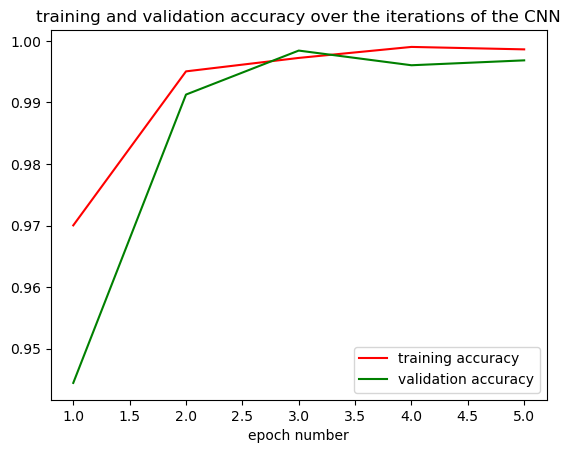

In [34]:
# reduction of the batch size 

# Building the CNN model
model2 = Sequential([
    Conv2D(32, kernel_size=(5, 5), activation='relu', input_shape=(96, 96, 3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(32, kernel_size=(5, 5), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(2, activation='softmax')
])

model2.summary()

model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


history2 = model2.fit(xtrain, ytrain, validation_data=(xval, yval), epochs=5, batch_size=32)

# display the evolution of the accuracy over the training iterations of the CNN.


indices=range(1,6)
plt.plot(indices,history2.history["accuracy"],color='r',label="training accuracy")
plt.plot(indices,history2.history["val_accuracy"],color='g',label="validation accuracy")


plt.xlabel("epoch number")
plt.title("training and validation accuracy over the iterations of the CNN")
plt.legend()
plt.show()


<function matplotlib.pyplot.show(close=None, block=None)>

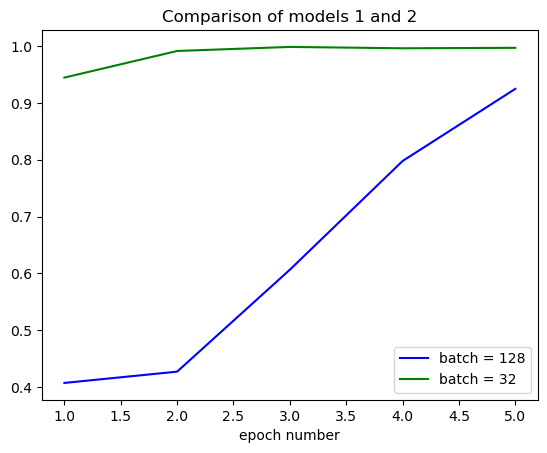

In [36]:
# comparison of our two models 


indices=range(1,6)
plt.plot(indices,history.history["val_accuracy"],color='b',label="batch = 128")
plt.plot(indices,history2.history["val_accuracy"],color='g',label="batch = 32")


plt.xlabel("epoch number")
plt.title("Comparison of models 1 and 2")
plt.legend()
plt.show


- **TODO: Final evaluation of the model:**
    - load the data (pickle file) from the test set with images 96 x 96 px
    - transform the labels with *to_categorical*
    - evaluate the performance of the model you selected on this final test set
    - are your satisfied ?
    - do you observe underfitting/overfitting on some models ?

In [37]:
# cf. the beginning for data loading 

eval_test=model2.evaluate(Xtest, ytest)

print("loss: " +str(eval_test[0]))

print("accuracy: {}".format(eval_test[1]))

62/62 [==============================] - 3s 48ms/step - loss: 0.0513 - accuracy: 0.9800
loss: 0.051315467804670334
accuracy: 0.9800307154655457


- save your model to the file "best_CNN.keras"

In [38]:
model2.save("best_CNN.keras")

# 2. Compression of the CNN with a combination of pruning and quantization

TensorFlow and TensorFlow Lite include compression mechanisms to decrease the load of a CNN in terms of memory and computation.

We will use:
- the library **tensorflow_model_optimization** for network pruning without and with fine-tuning.
- the library **tf.lite.TFLiteConverter** to convert our model with TensorFlow Lite, with an application of quantization.

Search the web for the documentation, it can be a little hard for these aspects so **don't give up**.

## Given funtions
We give you a small set of functions that will help you during the following of the lab.
These functions mainly serve
- to load models, write them to files, and estimate their size (see the doc of each function).
- to define specific extensions of the *tensorflow_optimization* package

In [39]:
def setup_model(model_file):
    """Setup a model from a file where is was written using e.g. model.save(filename)

    Parameters
    ----------
    model_file : str
        The file containing the model

    Returns
    -------
    tf_model
        the loaded model
    """
    
    model = load_model(model_file)
    return model

def save_pruned_model(model, model_file=None):
    """Save a pruned model after preprocessing it (strip pruneLowMagnitude layers)

    Parameters
    ----------
    model : tf_model
        The pruned model to save.
    model_file : str (Optional)
        The file where the model should be saved
        
    Returns
    -------
    tf_model
        The preprocessed model for export
    str
        The file where the model has been saved
    """
    model_for_export = tfmot.sparsity.keras.strip_pruning(model)
    
    if model_file is None:
        _, model_file = tempfile.mkstemp('.h5')
    tf.keras.models.save_model(model_for_export, model_file, include_optimizer=False)
    
    return model_for_export, model_file

def get_gzipped_model_size(model=None, keras_file=None, zipped_file=None):
    """Model size estimation:
    Write a model to a file, compress it using gzip and return the file size

    Parameters (at least one of the 3)
    ----------
    model : tf_model (optional)
        The model to estimate.
    keras_file : str (optional)
        The name of the file where the model is saved.
    zipped_file : str (optional)
        The name of the file containing the compressed model.

    Returns
    -------
    str
        The name of the file where the model is saved.
    str
        The name of the file containing the compressed model.
    int
        The size of the compressed model
    """    
    if model is not None:
        if keras_file is None:
            _, keras_file = tempfile.mkstemp('.h5')
        model.save(keras_file, include_optimizer=False)
        
        _, zipped_file = tempfile.mkstemp('.zip')
    
        with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
            f.write(keras_file)
    elif keras_file is not None:
        _, zipped_file = tempfile.mkstemp('.zip')
    
        with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
            f.write(keras_file)
    elif zipped_file is None:
        raise ValueError("You must provide at least model, keras_file, or zipped file")

    return keras_file, zipped_file, math.ceil(os.path.getsize(zipped_file))

def print_model_weights_sparsity(model):
    """Display the sparsity of each layer in a model

    Parameters
    ----------
    model : tf_model (optional)
        The model to analyze.
    """
    stripped_pruned_model = tfmot.sparsity.keras.strip_pruning(model)
    for layer in stripped_pruned_model.layers:
        if isinstance(layer, tf.keras.layers.Wrapper):
            weights = layer.trainable_weights
        else:
            weights = layer.weights
        for weight in weights:
            if "kernel" not in weight.name or "centroid" in weight.name:
                continue
            weight_size = weight.numpy().size
            zero_num = np.count_nonzero(weight == 0)
            print(
                f"{weight.name}: {zero_num/weight_size:.2%} sparsity ",
                f"({zero_num}/{weight_size})",
            )

def apply_constant_prune(model, sparsity, only_dense=1):
    """Calls tfmot.sparsity.keras.prune_low_magnitude with the possibility to only run on dense layers

    Parameters
    ----------
    model : tf_model
        The model to prune.
    sparsity : float
        The sparsity level to apply ConstantSparsity
    only_dense : int (default=1)
        Do we only apply pruning on the dense layers ?
        
    Returns
    -------
    tf_model
        the pruned model
    """
    def apply_pruning_to_dense(layer):
        if only_dense and isinstance(layer, tf.keras.layers.Dense):
            return tfmot.sparsity.keras.prune_low_magnitude(layer, ConstantSparsity(sparsity, 0))
        return layer
    model_for_pruning = clone_model(model, clone_function=apply_pruning_to_dense)
    return model_for_pruning

## 1.1 Network pruning

First, we will compress our CNN using a particular approach to network pruning using the function *ConstantSparsity* from the package **tfmot.sparsity.keras**: https://www.tensorflow.org/model_optimization/api_docs/python/tfmot/sparsity/keras/ConstantSparsity.


<img src="https://miro.medium.com/v2/resize:fit:828/format:webp/1*nicFUkeUpWMW1w_hUVtZiw.png" alt="CNN example" />

This process in done in 3 steps:
- decide on the pruning function: pruning_schedule = tfmot.sparsity.keras.ConstantSparsity(...)
- build your pruning model: pruned_model = apply_constant_prune(model, sparsity, only_dense=1)
- compile and fit: the pruning model is applied during training !
=> the new model can be used for prediction, etc.


*Remark*: these steps could be repeated in an iterative process (see Lecture), but we will not do it here to decrease computation time.

- **TODO: Load the data** (yes, again)
    - training set (do not forget *to_categorical*) and split it as train/validation sets
    - final test set (no splitting)

In [47]:
# load the data
with open("data_train_96_96_3.pickle", 'rb') as file:
    train_dict = pickle.load(file)
X = train_dict['data']
y = train_dict['labels']

with open("data_test_96_96_3.pickle", 'rb') as file:
    test_dict = pickle.load(file)
Xtest = test_dict['data']
ytest = test_dict['labels']



# split the data between train and validation 
xtrain, xval, ytrain, yval = train_test_split(X, y, train_size=0.8)


# Convert labels to categorical (one-hot encoding)
ytrain = to_categorical(ytrain)
ytest = to_categorical(ytest)
yval = to_categorical(yval)


- Load the model obtained before (done)

In [48]:
base_model = setup_model("best_CNN.keras")
baseline_model_loss, baseline_model_accuracy = base_model.evaluate(Xtest, ytest, verbose=0)
print('Baseline test accuracy:', baseline_model_accuracy)
base_model.summary()

Baseline test accuracy: 0.9800307154655457
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 92, 92, 32)        2432      
_________________________________________________________________
batch_normalization_2 (Batch (None, 92, 92, 32)        128       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 46, 46, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 42, 42, 32)        25632     
_________________________________________________________________
batch_normalization_3 (Batch (None, 42, 42, 32)        128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 21, 21, 32)        0         
_________________________________________________________________
flatten_1 (

- Pruning the model: the parameter *sparsity* for *ConstantSparsity* allows to choose the level of pruning applied.
    - The model should be trained (fit 2 epochs) in order to actually prune the network.
    - There is a callback parameter in the fit function which we provide below:
        - *UpdatePruningStep* is the option to apply pruning at each step of gradient descent,
        - *tfmot.sparsity.keras.PruningSummaries* allows to follow the evolution of the sparsity,
        - launch in a new terminal *tensorboard --logdir={log_dir}* where log_dir is the one generated below.

In [49]:
log_dir = tempfile.mkdtemp()
print(log_dir)
callbacks = [
    tfmot.sparsity.keras.UpdatePruningStep(),
    tfmot.sparsity.keras.PruningSummaries(log_dir=log_dir)
]

/tmp/tmpoz8qde4w


2024-01-19 14:09:05.921222: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2024-01-19 14:09:05.921265: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2024-01-19 14:09:05.921322: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.


- **TODO: optimal pruning of the model**:
    - vary the level of sparsity and plot the evolution of
        - the accuracy for the pruned model (on train and validation),
        - the size of the original and new models as estimated by the provided function get_gzipped_model_size,
    - which choice of sparsity is the best ?
    - Save the corresponding model to the file "constant_pruning.h5" using save_pruned_model.

In [50]:
base_model = setup_model("best_CNN.keras")
pruned_model_08 = apply_constant_prune(base_model, .8, only_dense=1)

pruned_model_08.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history_08 = pruned_model_08.fit(xtrain, ytrain, validation_data=(xval, yval), epochs=2,callbacks=callbacks)


Epoch 1/2
  1/158 [..............................] - ETA: 3:33 - loss: 8.0466e-07 - accuracy: 1.0000

2024-01-19 14:09:10.171273: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2024-01-19 14:09:10.171347: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.


  2/158 [..............................] - ETA: 50s - loss: 4.4188e-05 - accuracy: 1.0000 

2024-01-19 14:09:10.526744: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2024-01-19 14:09:10.528097: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2024-01-19 14:09:10.530524: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: /tmp/tmpoz8qde4w/train/plugins/profile/2024_01_19_14_09_10
2024-01-19 14:09:10.532185: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to /tmp/tmpoz8qde4w/train/plugins/profile/2024_01_19_14_09_10/insa-09150.trace.json.gz
2024-01-19 14:09:10.534640: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: /tmp/tmpoz8qde4w/train/plugins/profile/2024_01_19_14_09_10
2024-01-19 14:09:10.534795: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for memory_profile.json.gz to /tmp/tmpoz8qde4w/train/plugins/profile/2024_01_19_14_09_10/insa-09150.memory_pro

158/158 [==============================] - 47s 294ms/step - loss: 0.0517 - accuracy: 0.9860 - val_loss: 0.0236 - val_accuracy: 0.9937
Epoch 2/2
158/158 [==============================] - 51s 320ms/step - loss: 0.0073 - accuracy: 0.9981 - val_loss: 0.0097 - val_accuracy: 0.9960


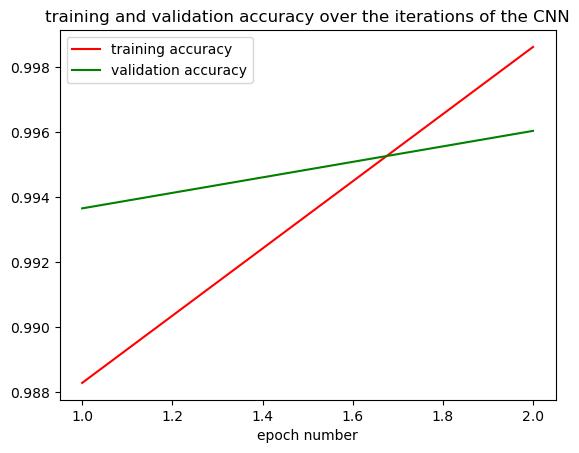

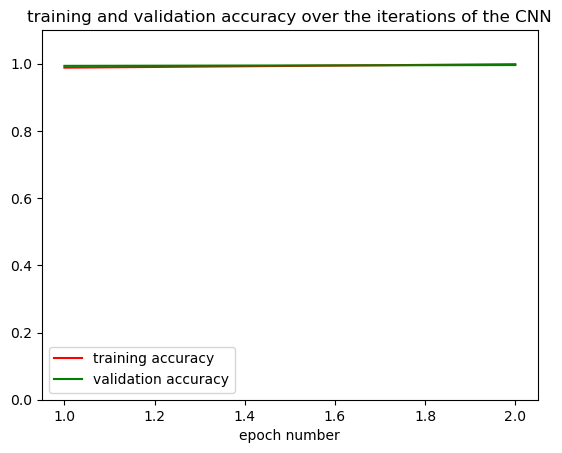

size of the original model: 3440569
size of the pruned model: 1347520


In [56]:
indices=range(1,3)
plt.plot(indices,history_08.history["accuracy"],color='r',label="training accuracy")
plt.plot(indices,history_08.history["val_accuracy"],color='g',label="validation accuracy")


plt.xlabel("epoch number")
plt.title("training and validation accuracy over the iterations of the CNN")
plt.legend()
plt.show()

plt.plot(indices,history_08.history["accuracy"],color='r',label="training accuracy")
plt.plot(indices,history_08.history["val_accuracy"],color='g',label="validation accuracy")
plt.ylim(0,1.1)

plt.xlabel("epoch number")
plt.title("training and validation accuracy over the iterations of the CNN")
plt.legend()
plt.show()

base_model = setup_model("best_CNN.keras")
print("size of the original model: " + str(get_gzipped_model_size(base_model)[2]))
print("size of the pruned model: " + str(get_gzipped_model_size(pruned_model_08)[2]))



Epoch 1/2
  1/158 [..............................] - ETA: 3:57 - loss: 1.2505e-04 - accuracy: 1.0000

2024-01-19 14:18:03.923050: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2024-01-19 14:18:03.923094: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.


  2/158 [..............................] - ETA: 53s - loss: 1.1704e-04 - accuracy: 1.0000 

2024-01-19 14:18:04.295825: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2024-01-19 14:18:04.297744: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2024-01-19 14:18:04.301239: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: /tmp/tmpoz8qde4w/train/plugins/profile/2024_01_19_14_18_04
2024-01-19 14:18:04.303096: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to /tmp/tmpoz8qde4w/train/plugins/profile/2024_01_19_14_18_04/insa-09150.trace.json.gz
2024-01-19 14:18:04.306388: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: /tmp/tmpoz8qde4w/train/plugins/profile/2024_01_19_14_18_04
2024-01-19 14:18:04.306523: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for memory_profile.json.gz to /tmp/tmpoz8qde4w/train/plugins/profile/2024_01_19_14_18_04/insa-09150.memory_pro

158/158 [==============================] - 53s 330ms/step - loss: 0.0683 - accuracy: 0.9797 - val_loss: 0.2855 - val_accuracy: 0.8714
Epoch 2/2
158/158 [==============================] - 51s 324ms/step - loss: 0.0280 - accuracy: 0.9920 - val_loss: 0.0266 - val_accuracy: 0.9897


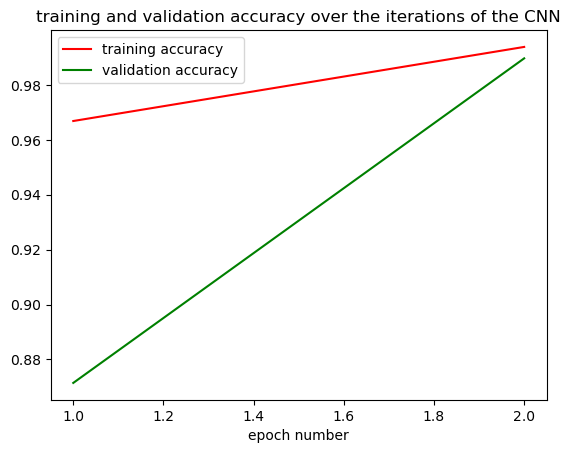

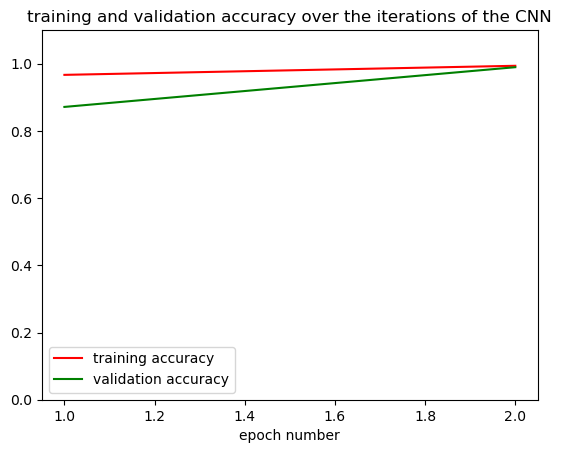

size of the original model: 3440571
size of the pruned model: 919300


In [57]:
# pruning 90%
base_model = setup_model("best_CNN.keras")
pruned_model_09 = apply_constant_prune(base_model, .9, only_dense=1)

pruned_model_09.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history_09 = pruned_model_09.fit(xtrain, ytrain, validation_data=(xval, yval), epochs=2,callbacks=callbacks)

indices=range(1,3)
plt.plot(indices,history_09.history["accuracy"],color='r',label="training accuracy")
plt.plot(indices,history_09.history["val_accuracy"],color='g',label="validation accuracy")


plt.xlabel("epoch number")
plt.title("training and validation accuracy over the iterations of the CNN")
plt.legend()
plt.show()

plt.plot(indices,history_09.history["accuracy"],color='r',label="training accuracy")
plt.plot(indices,history_09.history["val_accuracy"],color='g',label="validation accuracy")
plt.ylim(0,1.1)

plt.xlabel("epoch number")
plt.title("training and validation accuracy over the iterations of the CNN")
plt.legend()
plt.show()

base_model = setup_model("best_CNN.keras")
print("size of the original model: " + str(get_gzipped_model_size(base_model)[2]))
print("size of the pruned model: " + str(get_gzipped_model_size(pruned_model_09)[2]))


Epoch 1/2
  1/158 [..............................] - ETA: 4:44 - loss: 7.1253e-05 - accuracy: 1.0000

2024-01-19 14:19:51.031287: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2024-01-19 14:19:51.031326: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.


  2/158 [..............................] - ETA: 59s - loss: 7.7549e-05 - accuracy: 1.0000 

2024-01-19 14:19:51.473931: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2024-01-19 14:19:51.476309: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2024-01-19 14:19:51.480051: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: /tmp/tmpoz8qde4w/train/plugins/profile/2024_01_19_14_19_51
2024-01-19 14:19:51.482138: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to /tmp/tmpoz8qde4w/train/plugins/profile/2024_01_19_14_19_51/insa-09150.trace.json.gz
2024-01-19 14:19:51.485581: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: /tmp/tmpoz8qde4w/train/plugins/profile/2024_01_19_14_19_51
2024-01-19 14:19:51.485752: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for memory_profile.json.gz to /tmp/tmpoz8qde4w/train/plugins/profile/2024_01_19_14_19_51/insa-09150.memory_pro

158/158 [==============================] - 55s 341ms/step - loss: 0.1145 - accuracy: 0.9590 - val_loss: 0.5678 - val_accuracy: 0.6881
Epoch 2/2
158/158 [==============================] - 54s 341ms/step - loss: 0.3623 - accuracy: 0.9010 - val_loss: 0.3125 - val_accuracy: 0.8714


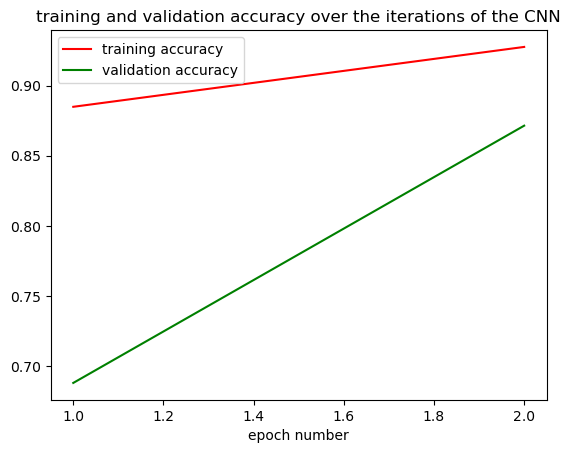

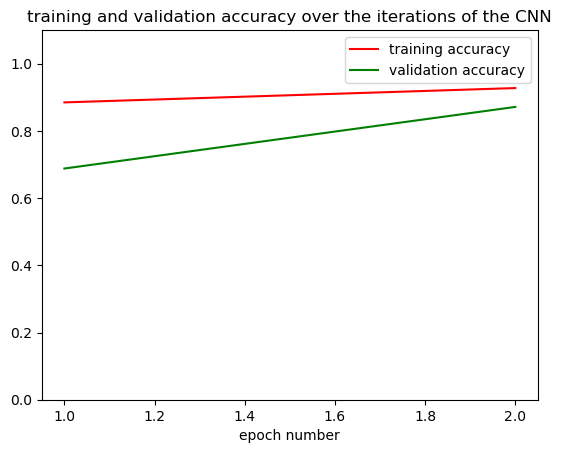

size of the original model: 3440570
size of the pruned model: 434035


In [58]:
# pruning 99%
base_model = setup_model("best_CNN.keras")
pruned_model_099 = apply_constant_prune(base_model, .99, only_dense=1)

pruned_model_099.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history_099 = pruned_model_099.fit(xtrain, ytrain, validation_data=(xval, yval), epochs=2,callbacks=callbacks)

indices=range(1,3)
plt.plot(indices,history_099.history["accuracy"],color='r',label="training accuracy")
plt.plot(indices,history_099.history["val_accuracy"],color='g',label="validation accuracy")


plt.xlabel("epoch number")
plt.title("training and validation accuracy over the iterations of the CNN")
plt.legend()
plt.show()

plt.plot(indices,history_099.history["accuracy"],color='r',label="training accuracy")
plt.plot(indices,history_099.history["val_accuracy"],color='g',label="validation accuracy")
plt.ylim(0,1.1)

plt.xlabel("epoch number")
plt.title("training and validation accuracy over the iterations of the CNN")
plt.legend()
plt.show()

base_model = setup_model("best_CNN.keras")
print("size of the original model: " + str(get_gzipped_model_size(base_model)[2]))
print("size of the pruned model: " + str(get_gzipped_model_size(pruned_model_099)[2]))


Epoch 1/2
  1/158 [..............................] - ETA: 4:02 - loss: 7.3063e-04 - accuracy: 1.0000

2024-01-19 14:21:41.781442: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2024-01-19 14:21:41.781484: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.


  2/158 [..............................] - ETA: 54s - loss: 0.0056 - accuracy: 1.0000     

2024-01-19 14:21:42.144733: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2024-01-19 14:21:42.146254: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2024-01-19 14:21:42.148351: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: /tmp/tmpoz8qde4w/train/plugins/profile/2024_01_19_14_21_42
2024-01-19 14:21:42.149610: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to /tmp/tmpoz8qde4w/train/plugins/profile/2024_01_19_14_21_42/insa-09150.trace.json.gz
2024-01-19 14:21:42.151372: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: /tmp/tmpoz8qde4w/train/plugins/profile/2024_01_19_14_21_42
2024-01-19 14:21:42.151453: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for memory_profile.json.gz to /tmp/tmpoz8qde4w/train/plugins/profile/2024_01_19_14_21_42/insa-09150.memory_pro

158/158 [==============================] - 53s 326ms/step - loss: 0.0704 - accuracy: 0.9851 - val_loss: 0.0301 - val_accuracy: 0.9944
Epoch 2/2
158/158 [==============================] - 47s 299ms/step - loss: 0.0065 - accuracy: 0.9987 - val_loss: 0.0070 - val_accuracy: 0.9968


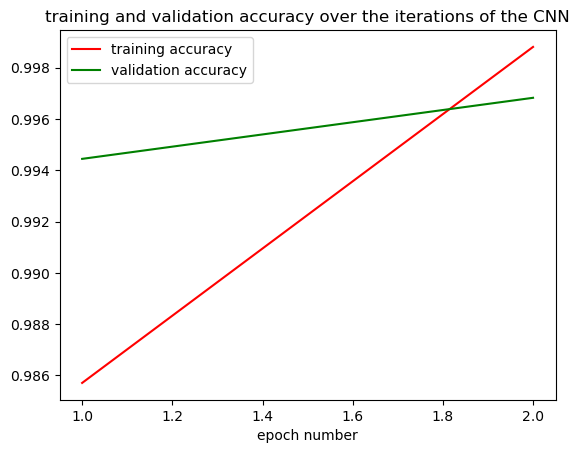

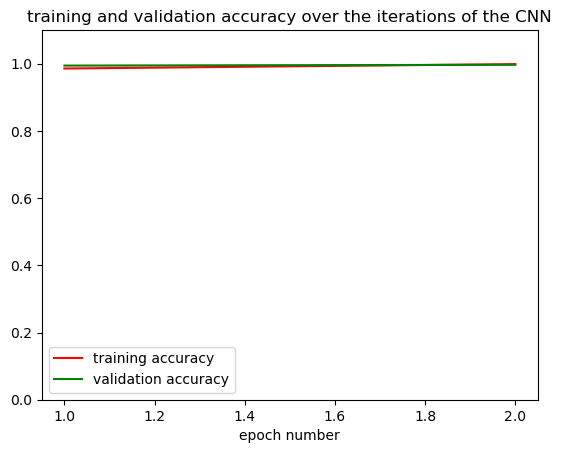

size of the original model: 3440569
size of the pruned model: 1730335


In [59]:
# pruning 70%
base_model = setup_model("best_CNN.keras")
pruned_model_07 = apply_constant_prune(base_model, .7, only_dense=1)

pruned_model_07.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history_07 = pruned_model_07.fit(xtrain, ytrain, validation_data=(xval, yval), epochs=2,callbacks=callbacks)

indices=range(1,3)
plt.plot(indices,history_07.history["accuracy"],color='r',label="training accuracy")
plt.plot(indices,history_07.history["val_accuracy"],color='g',label="validation accuracy")


plt.xlabel("epoch number")
plt.title("training and validation accuracy over the iterations of the CNN")
plt.legend()
plt.show()

plt.plot(indices,history_07.history["accuracy"],color='r',label="training accuracy")
plt.plot(indices,history_07.history["val_accuracy"],color='g',label="validation accuracy")
plt.ylim(0,1.1)

plt.xlabel("epoch number")
plt.title("training and validation accuracy over the iterations of the CNN")
plt.legend()
plt.show()

base_model = setup_model("best_CNN.keras")
print("size of the original model: " + str(get_gzipped_model_size(base_model)[2]))
print("size of the pruned model: " + str(get_gzipped_model_size(pruned_model_07)[2]))


## Best model 

We choose the model pruned by 90% because it is the best compromised between accuracy and size reduction.

 - **TODO: For the selected model, evaluate the performance on the final test set**

In [64]:

test_eval = pruned_model_09.evaluate(Xtest, ytest)
print("Performance on the final test set: \n")
print("loss: {}, accuracy: {}".format(test_eval[0],test_eval[1]))
base_model = setup_model("best_CNN.keras")
base= get_gzipped_model_size(base_model)[2]
pruned=get_gzipped_model_size(pruned_model_09)[2]
print("size of the original model: " + str(base))
print("size of the pruned model: " + str(pruned))
reduc = pruned/base * 100
print("the new model is only " + str(reduc) + "% the size of the original")

save_pruned_model(pruned_model_09,"constant_pruning.h5")





62/62 [==============================] - 3s 51ms/step - loss: 0.1174 - accuracy: 0.9595
Performance on the final test set: 

loss: 0.11738403141498566, accuracy: 0.9595494270324707
size of the original model: 3440571
size of the pruned model: 919299
the new model is only 26.719373034301576% the size of the original


(<tensorflow.python.keras.engine.sequential.Sequential at 0x7f4d2dce38d0>,
 'constant_pruning.h5')

## 1.2 Quantization

Secondly, we will compress our CNN using quantization optimization as implemented in TensorFlow Lite.
The quantization is directly performed during the conversion of the TensorFlow model in a file .tflite.

This file can be used directly by a TensorFlow Lite interpreter on an embedded device (if small enough) !

## Given funtions
We give you a small set of functions that will help you during the following of the lab.
These functions mainly serve
- to write them to files (see the doc of each function),
- to evaluate the accuracy of the tensorflow lite model.

In [65]:
def save_tflite_model(model, model_file=None):
    """Save a TensorFlow Lite model to a file

    Parameters
    ----------
    model : tflite_model
        The tflite model to save.
    model_file : str (Optional)
        The file where the model should be saved
        
    Returns
    -------
    str
        The file where the model has been saved
    """
    if model_file is None:
        _, model_file = tempfile.mkstemp('.tflite')
    with open(model_file, 'wb') as f:
        f.write(model)

    return model_file

def tflite_evaluate(X, y, model=None, model_file=None):
    """Evaluate a TensorFlow Lite model
    
    Parameters
    ----------
    X, y : list, list
        The labeled dataset
    model : tf_model_lite (Optional)
        The model to evaluate
    model_file : str (Optional)
        The file where the model is saved
        
    Returns
    -------
    float
        The accuracy of the model on the dataset
    """
    if model is None and model_file is None:
        raise ValueError("tflite_evaluate: give either model or model_file")
    
    # Load and run the TensorFlow Lite model on test data
    if model is not None:
        interpreter = tf.lite.Interpreter(model_pcontent=model)
    else:
        interpreter = tf.lite.Interpreter(model_path=model_file)
    interpreter.allocate_tensors()

    input_index = interpreter.get_input_details()[0]["index"]
    output_index = interpreter.get_output_details()[0]["index"]

    # Evaluate the model
    prediction_digits = []
    for test_image in X:
        test_image = np.expand_dims(test_image, axis=0).astype(np.float32)
        interpreter.set_tensor(input_index, test_image)

        interpreter.invoke()

        output = interpreter.tensor(output_index)
        digit = np.argmax(output()[0])
        prediction_digits.append(digit)
        
    tflite_qaware_accuracy = (np.array(prediction_digits) == np.argmax(y, axis=1)).mean()
    return tflite_qaware_accuracy

def convert_to_TFLite(model, optimizations=None):
    """Convert a model to TensorFlow Lite format with possible optimizations
    
    Parameters
    ----------
    model : tf_model
        The model to convert
    optimizations : list (Optional)
        The optimization options
        
    Returns
    -------
    tflite_model
        The converted model
    """
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    if optimizations is not None:
        converter.optimizations = optimizations
    quant_tflite_model = converter.convert()
    return quant_tflite_model

- Load the pruned model obtained before

In [66]:
pruned_model = setup_model("constant_pruning.h5")
pruned_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) 

- **TODO: convert the model to the TensorFlow Lite format**
    - use *convert_to_TFLite* for the conversion: look inside this function and explain very briefly the steps it follows,
    - use *save_tflite_model* to save the obtained model to the file "pruning_quant.tflite".

- this function transforms our model to a tensorflow lite model that can be interpreted on an embedded device. It creates a converter from the model, then applies the eventual optimizations, and finally converts the model. 

In [76]:
tflitemodel= convert_to_TFLite(pruned_model,optimizations=[tf.lite.Optimize.DEFAULT])

save_tflite_model(tflitemodel,"pruning_quant.tflite")

INFO:tensorflow:Assets written to: /tmp/tmp0e_xjngo/assets


INFO:tensorflow:Assets written to: /tmp/tmp0e_xjngo/assets
2024-01-19 14:49:02.897766: I tensorflow/core/grappler/devices.cc:69] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-01-19 14:49:02.897994: I tensorflow/core/grappler/clusters/single_machine.cc:356] Starting new session
2024-01-19 14:49:02.898251: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-01-19 14:49:02.902091: I tensorflow/core/grappler/optimizers/meta_optimizer.cc:928] Optimization results for grappler item: graph_to_optimize
  function_optimizer: function_optimizer did nothing. time = 0.005ms.
  function_optimizer: function_optimizer did nothing. time = 0.001ms.

2024-01-19 14:49:03.037358: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:316] Ignored output_format.
2024-01-19 14:49:03.037418: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:319] Ignored drop_control_dependency.
2024-01-1

'pruning_quant.tflite'

- **TODO: evaluate your results**: for the base model, the pruned model, and the tflite model
    - display the size of the model using *get_gzipped_model_size*. For the tflite model, input the *.tflite* directly with the parameter keras_file.
    - display the accuracy obtained on the final test set. For the tflite model:
        - use the function *tflite_evaluate* to get the accuracy,
        - look inside this function and explain very briefly the steps it follows.

In [82]:
base_model = setup_model("best_CNN.keras")
pruned_model = setup_model("constant_pruning.h5")
base= get_gzipped_model_size(base_model)[2]
light=get_gzipped_model_size(keras_file="pruning_quant.tflite")[2]
pruned=get_gzipped_model_size(pruned_model)[2]
print("size of the original model: " + str(base))
print("size of the pruned model: " + str(pruned))
print("size of the light model: " + str(light))
diffBase = light/base *100
diffPruned = light/pruned*100
print("The lite model is {}% of the pruned model and by extension {}% of the base model".format(diffPruned,diffBase))


eval_base=base_model.evaluate(Xtest,ytest)
pruned_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) 
eval_pruned=pruned_model.evaluate(Xtest,ytest)

eval_lite=tflite_evaluate(Xtest, ytest, model_file="pruning_quant.tflite")
print("the accuracy on the final test set is: ")
print("base model: {}".format(eval_base[1]))
print("pruned model: {}".format(eval_pruned[1]))
print("lite model: {}".format(eval_lite))

size of the original model: 3440571
size of the pruned model: 802142
size of the light model: 196722
The lite model is 24.52458542253117% of the pruned model and by extension 5.717713716705744% of the base model
62/62 [==============================] - 4s 56ms/step - loss: 0.0981 - accuracy: 0.9598
the accuracy on the final test set is: 
base model: [0.051315467804670334, 0.9800307154655457]
pruned model: [0.11738403141498566, 0.9595494270324707]
lite model: 0.9600614439324117


- **TODO: Questions**:
    - Are you satisfied with the results of the compression ?
    - Analyse in terms of accuracy, model size.
    - What possible benefits can you hope for embedding in a device ? Give at least 3.

- The results of the compression are very satistactory from a model size and accuracy point of view. 
- Pruning and quantization permit a reduction of the model size. The final model is only five per cent of the initial size, while conserving similar accuracy compared to the initial model (-2%), and even a better accuracy than the pruned model. 
- We can think of the following benefits for embedding in a device : 
    - smaller size on disk 
    - less weights (pruning) implies less computationnal power to use the model 
    - TFlite interpreter can adapt to the hardware for efficient execution (even if on this machine it took five minutes)

# 3. Development of a Fall Detection System (FDS) in production

In this part, we ask you to use the lectures, the labs, your own culture, and your imagination.

A few directions:
- You can answer to this part directly inside the jupyter-notebook or on a separate pdf file to send together with your notebook.
- The length is limited to the equivalent of 2 pages of content, **no more !**
- We prefer 1 page with content that is synthetic, over 10 pages of gibberish.
- We advice that your group of 2 think about this part over a coffee, a tea, or any beverage/food that you prefer...

Up to now:
- you have set up a classification model for Human Activity Recognition using data from sensors on the person's body (ankle, wrist, and chest).
- you have set up a compressed CNN model for embedded fall detection using images from a video camera.

### **Question to develop** : How would you build a fall detection system for old people’s homes ("maisons de retraite") ? Be creative !

Your answer should **include** answers to these aspects:
- Application itself
    - Does this problem correspond to an application of AI at the edge ? How so ?
    - BLERP analysis
- Method developped
    - Machine learning
        - Is it a supervised or unsupervised learning problem ?
        - Where does the training happen ?
        - What mechine learning approach do you consider ? What constraints should drive your choice ?
    - Getting and combining data
        - Do you need additional data for your application ?
        - Using sensor data and image data, how do you combine them ? Synchronisation/Ensemble learning ?
        - What happens if the elder is outside of the field of vision of the camera ?
    - What type of hardware would you use (no need to specific chip names, just the general type: CPU/GPU/TPU/Laptop/microcontrollers, security cameras/smartwatches/smartphones, etc.)
    - Give an idea of the steps you would follow to develop the whole fall detection system
- Final validation and production
    - Which validation method will you use ?
    - Where do you embed and run the final model ?
    - Once your model is deployed, will you need to update it ? When/How ?

**REPORT**

**1 - Application**

Our application is a fall detection system for elderly persons in a retirement home. This application correspond to an application of AI at the edge. Indeed, as it concerns the health of the patients, the latency is crucial. For the medical field, the data is often confidential so it is relevant to run this application on the edge.

An important thing to do when creating an AI application is to look at the BLERP criterias. In our case, we have the following needs:

  - Bandwidth : As we plan to make everything run locally on the edge, the bandwidth is not critical
  - Latency: The latency is crucial. Indeed, we need to detect a fall as soon as possible in order to call a nurse present in the retirement home or the emergencies quickly that could come to help the elderly person.
  - Economics: The economic point is not critical in this case. As the target for this product is retirement home and not directly the elderly persons.
  - Reliability: The decisions taken by our AI need to be reliable. Indeed, we do not want to call the emergencies if no one fell but more importantly, if someone fell, we have to be sure that our system detects it for obvious health reasons. This will have to be taken into account when we analyse the confusion matrix of our models during training. 
  - Privacy: Privacy is one of the most important criteria in our case. Indeed, as it deals with the medical fields and the health of the patients we have to be concerned by the privacy of the residents. 

**2 - Development Method**

To answer the criteria that we have for our application, we need to develop a supervised machine learning model. We need it to make classification on certain kind of data (that we will explain in the next part) to detect if someone fell or not. For classification problems supervised training is prefered.

To define our model, we I thought about in fact implementing two distinct AIs. One would run on a server present in the retirement home with a CPU and a GPU. The AI on this machine would be responsible to analyse the images of the security camera of the retirement home in order to detect a fall. This solution can be costly but as we mentioned that the economic criteria is not really important for us we think that it is acceptable. 

The other system would be an embedded system on a microcontroller that we could put in a bracelet and give it to the residents of the retirement home. This AI would also be responsible of detecting the falls but using from sensors in the bracelet (for example an accelerometer). This AI would be much cheaper than the previous one and would allow us to detect a fall in a case where the resident is not in sight of a security camera.

As we would train our model using online datasets of falls (both accelerometers and images) there would be no danger for the privacy criteria which would allow us to run the training in the cloud for better performances and faster learning time. However for the AI running on the server (image analysis) it has to be able to detect if someone is present on the image before being able to detect a fall. Because of this we would have to train this AI to detect the presence of someone and only run the detection of a fall if someone is detected on the frame. To do so, we would either have to find a dataset online to detect the presence of someone from the perspective of a security camera or take the recordings of the camera of the retirement home to train the AI. In the last case, we would have to train the AI locally on the server and not on the cloud for privacy reasons. Thus, we would implement two Convolutionnal Neural Networks (CNN), one to detect a person on a frame and one to detect a fall from the cropped image of the person detected by the first CNN. 

For the model embedded in the bracelet, we choose a simple neural network. It would need to be trained and we could also optimize the hyper parameters to get the best results (size and number of the layers, number of epochs). Then, to embed the model, we would need to convert it to a tensorflow lite model to make it able to run on a microcontroller with an optimized interpreter. 

To do so, the steps are the following : 
- Developp and train the neural network
- Prune the model to reduce its size
- Convert it to a tensorflow lite model with some optimizations
- Embedded it on the device with an optimized interpreter

For the AI on the server, we could also apply some pruning, followed by a new iteration of training, as it tends to better the accuracy and makes the model quicker to run on new examples. 

**3 - Final Validation**

To validate our three models, we would split our data into training, validation and test data. For the training and validation, we can use k-fold validation to make sure our accuracy is not biased and that we avoid overfitting. After that we test the models on the test dataset for final performance analyzis.

After that, we can implement the final models respectively on a bracelet and the server connected to security cameras to test a broad variaty of fall (fast, slow ...) to make sure it is able to detect it within the BLERP conditions. 

An advantage of this system is that we theoretically do not need to update it. Indeed, there is no particular reasons that the performances of our system would decreases over time. However we could potentially update the system if we can find better optimizations or increase the accuracy. 